# Connecting to Eikon Data API

In [56]:
import refinitiv.data as rd
import refinitiv.data.eikon as ek
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
from refinitiv.data import content, session
from scipy.optimize import minimize

from pprint import pprint
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [4]:
rd.open_session()

<refinitiv.data.session.Definition object at 0x3190d9bd0 {name='workspace'}>

In [8]:
# Get constituents of the FTSE 100 index
constituents_data = ek.get_data(
    instruments=['0#.FTSE'],
    fields=['TR.CommonName', 'TR.GICSSectorName', 'TR.PrimaryQuote']
)[0]  # [0] to get the DataFrame from the result tuple

print(constituents_data)

   Instrument              Company Common Name Primary Quote RIC
0      STAN.L           Standard Chartered PLC            STAN.L
1      CRDA.L          Croda International PLC            CRDA.L
2      ANTO.L                  Antofagasta PLC            ANTO.L
3       EZJ.L                      Easyjet PLC             EZJ.L
4      BNZL.L                        Bunzl plc            BNZL.L
..        ...                              ...               ...
95     ULVR.L                     Unilever PLC            ULVR.L
96     OCDO.L                  Ocado Group PLC            OCDO.L
97     LSEG.L  London Stock Exchange Group PLC            LSEG.L
98     TSCO.L                        Tesco PLC            TSCO.L
99     LGEN.L        Legal & General Group PLC            LGEN.L

[100 rows x 3 columns]


In [9]:
ind_const, err = ek.get_data(
        instruments = constituents_data['Primary Quote RIC'].tolist(),
        fields = ['TR.CommonName','TR.CompanyMarketCap', "TR.TRBCIndustryGroup", "TR.TRESGScore"])

ind_const

,Instrument,Company Common Name,Company Market Cap,TRBC Industry Group Name,ESG Score
0,STAN.L,Standard Chartered PLC,19973082567.9683,Banking Services,91.992196
1,CRDA.L,Croda International PLC,6450054878.03459,Chemicals,80.448773
2,ANTO.L,Antofagasta PLC,22095513898.876202,Metals & Mining,77.346326
3,EZJ.L,Easyjet PLC,3460561825.4991,Passenger Transportation Services,54.559892
4,BNZL.L,Bunzl plc,10193830661.312799,Diversified Industrial Goods Wholesale,48.196805
...,...,...,...,...,...
95,ULVR.L,Unilever PLC,107327527362.231995,Personal & Household Products & Services,89.380916
96,OCDO.L,Ocado Group PLC,3096259364.07664,Diversified Retail,67.810071
97,LSEG.L,London Stock Exchange Group PLC,49431327922.915298,Investment Banking & Investment Services,75.824323
98,TSCO.L,Tesco PLC,22018886272.908401,Food & Drug Retailing,79.19792


In [10]:
# Applying the function
top_per_sector = ind_const.sort_values(by=['Company Market Cap', 'ESG Score'], ascending=False).head(100)

top_per_sector.reset_index(drop=True, inplace=True)
top_per_sector

,Instrument,Company Common Name,Company Market Cap,TRBC Industry Group Name,ESG Score
0,AZN.L,AstraZeneca PLC,190213774762.570007,Pharmaceuticals,95.504923
1,SHEL.L,Shell PLC,175958554267.259003,Oil & Gas,93.477656
2,HSBA.L,HSBC Holdings PLC,129859028640.207001,Banking Services,78.011392
3,ULVR.L,Unilever PLC,107327527362.231995,Personal & Household Products & Services,89.380916
4,RIO.L,Rio Tinto PLC,96136832830.305893,Metals & Mining,70.216734
...,...,...,...,...,...
95,BRBY.L,Burberry Group PLC,3705280439.87043,Specialty Retailers,78.987766
96,RS1R.L,RS Group PLC,3502718642.88085,Electronic Equipment & Parts,60.282361
97,EZJ.L,Easyjet PLC,3460561825.4991,Passenger Transportation Services,54.559892
98,OCDO.L,Ocado Group PLC,3096259364.07664,Diversified Retail,67.810071


In [6]:
ric = top_per_sector["Instrument"].to_list()

In [9]:
# Split the RIC list into 4 chunks
chunk_size = len(ric) // 4
ric_chunks = [ric[i:i + chunk_size] for i in range(0, len(ric), chunk_size)]

# Initialize an empty DataFrame to store the portfolio data
portfolio = pd.DataFrame()

# Fetch data for each chunk
for chunk in ric_chunks:
    for r in chunk:
        try:
            data, err = ek.get_data(r, fields=[ek.TR_Field('tr.close'), ek.TR_Field('tr.close.date')],
                                    parameters={"SDate": "2000-01-01", "EDate": "2024-05-01"})
            if not isinstance(data, pd.DataFrame):
                data = pd.DataFrame(data)
            
            # Append the data to the portfolio DataFrame
            portfolio = pd.concat([portfolio, data], ignore_index=True)
        except ek.RDError as e:
            print(f"Error fetching data for {r}: {e.message} (Error code: {e.code})")

# Optional: Output the final portfolio DataFrame to inspect the result
print(portfolio)

       Instrument  Price Close                  Date
0           AZN.L  2392.339763  2000-01-04T00:00:00Z
1           AZN.L  2346.502026  2000-01-05T00:00:00Z
2           AZN.L  2341.625671  2000-01-06T00:00:00Z
3           AZN.L  2397.216118  2000-01-07T00:00:00Z
4           AZN.L  2463.534546  2000-01-10T00:00:00Z
...           ...          ...                   ...
614804      SJP.L        421.0  2024-04-25T00:00:00Z
614805      SJP.L        435.4  2024-04-26T00:00:00Z
614806      SJP.L        444.8  2024-04-29T00:00:00Z
614807      SJP.L        435.6  2024-04-30T00:00:00Z
614808      SJP.L        433.2  2024-05-01T00:00:00Z

[614809 rows x 3 columns]


In [10]:
#Drop all the rows where the instrument name is GLEN.L, HLN.L
# portfolio = portfolio[~portfolio['Instrument'].isin(['GLEN.L', 'HLN.L'])]
portfolio.groupby('Instrument').count()

,Price Close,Date
Instrument,,
AAF.L,1223,6147
AAL.L,6147,6147
ABF.L,6147,6147
ADML.L,4953,6147
AHT.L,6147,6147
...,...,...
UU.L,6147,6147
VOD.L,6147,6147
WEIR.L,6147,6147


In [11]:

# Convert 'Date' to datetime and normalize timezone if needed (remove timezone)
portfolio['Date'] = pd.to_datetime(portfolio['Date']).dt.tz_localize(None)

# Creating a full DataFrame assuming all combinations should exist
dates = pd.date_range(start='2000-01-01', end='2024-05-01', freq='D')
instruments = portfolio['Instrument'].unique()
full_index = pd.MultiIndex.from_product([dates, instruments], names=['Date', 'Instrument'])
full_df = pd.DataFrame(index=full_index).reset_index()

# Convert 'Date' in full_df to datetime and normalize timezone (since it's already without timezone, this is for demonstration)
full_df['Date'] = pd.to_datetime(full_df['Date'])

# Merge to find and handle missing data
merged_df = full_df.merge(portfolio, on=['Date', 'Instrument'], how='left')

# Check for missing data
missing_data = merged_df[merged_df['Price Close'].isna()]

# Step to handle duplicates: averaging 'Price Close' for same 'Date' and 'Instrument'
merged_df = merged_df.groupby(['Date', 'Instrument']).agg({'Price Close': 'mean'}).reset_index()

# Now pivot the DataFrame to the desired format
pivot_df = merged_df.pivot(index='Date', columns='Instrument', values='Price Close')

pivot_df = pivot_df.dropna(how='all')

# Displaying the first few rows of the pivoted DataFrame
pivot_df

Instrument,AAF.L,AAL.L,ABF.L,ADML.L,AHT.L,ANTO.L,AUTOA.L,AV.L,AZN.L,BAES.L,...,SVT.L,TSCO.L,TW.L,ULVR.L,UTG.L,UU.L,VOD.L,WEIR.L,WPP.L,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,<NA>,996.961318,327.61539,<NA>,154.593367,86.037092,<NA>,920.32412,2392.339763,408.5,...,625.338004,181.484681,88.529409,1013.333232,165.428281,529.350796,295.186056,231.0,970.0,538.21901
2000-01-05,<NA>,1005.684729,332.799959,<NA>,153.229308,86.037092,<NA>,893.154057,2346.502026,401.25,...,634.263903,184.480301,92.057755,1019.999898,165.428281,537.034921,280.914974,237.5,875.0,536.904143
2000-01-06,<NA>,1030.359522,364.401142,<NA>,151.410563,86.334798,<NA>,884.756038,2341.625671,404.75,...,682.56877,184.480301,94.303066,1053.333228,165.428281,557.952815,272.402399,249.0,867.5,543.04019
2000-01-07,<NA>,1066.74861,353.538236,<NA>,151.410563,86.334798,<NA>,904.516084,2397.216118,388.25,...,706.721203,181.983951,96.548378,1104.444334,165.428281,567.771419,287.67496,244.0,900.0,569.337536
2000-01-10,<NA>,1077.964425,357.241499,<NA>,146.863699,86.830975,<NA>,910.444097,2463.534546,380.25,...,699.370463,176.242345,93.34079,1064.444338,165.428281,577.163126,302.196411,243.5,943.5,552.244261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-25,108.5,2560.0,2686.0,2675.885688,5760.0,2227.0,688.6,458.5,12026.0,1320.0,...,2442.0,289.8,131.45,4082.0,917.0,1030.0,69.0,1967.0,796.4,3028.0
2024-04-26,109.8,2643.0,2635.0,2682.843786,6104.0,2255.0,695.4,463.8,11988.0,1340.0,...,2458.0,288.9,134.3,4133.0,932.0,1038.5,69.08,2010.0,812.4,3043.0
2024-04-29,112.1,2750.0,2654.0,2716.640262,5974.0,2282.0,696.6,467.9,12024.0,1355.0,...,2480.0,292.0,135.0,4105.0,933.5,1045.0,70.0,2042.0,817.2,3047.0


In [13]:
df_cleaned = pivot_df.dropna(how='all')
df_cleaned.isna().sum()

Instrument
AAF.L     4978
AAL.L       54
ABF.L       54
ADML.L    1248
AHT.L       54
          ... 
UU.L        54
VOD.L       54
WEIR.L      54
WPP.L       54
WTB.L       54
Length: 100, dtype: int64


In [14]:
# Drop rows where all elements are NaN
df_cleaned = pivot_df.dropna(how='all')

# Calculate the number of NaN values for each RIC
na_counts = df_cleaned.isna().sum()

# Filter out the RICs with more than 100 NaN values
ric_to_keep = na_counts[na_counts <= 100].index

# Create a new DataFrame with only the filtered RICs
filtered_pivot_df = pivot_df[ric_to_keep]

# Optional: Output the final filtered DataFrame to inspect the result
filtered_pivot_df.shape

(6201, 70)

In [15]:
# List of columns with missing values
columns_with_missing = filtered_pivot_df.columns[filtered_pivot_df.isna().any()].tolist()
print(f"Columns with missing values: {columns_with_missing}")

# Apply backward fill for initial missing values
df_bfill_initial = filtered_pivot_df[columns_with_missing].fillna(method='bfill')

# Apply interpolation for remaining missing values
df_filled = df_bfill_initial.interpolate(method='linear')

# Replace original columns with filled data
filtered_pivot_df[columns_with_missing] = df_filled

# Validate the result
print(filtered_pivot_df.isna().sum())

Columns with missing values: ['AAL.L', 'ABF.L', 'AHT.L', 'ANTO.L', 'AV.L', 'AZN.L', 'BAES.L', 'BARC.L', 'BATS.L', 'BDEV.L', 'BKGH.L', 'BNZL.L', 'BP.L', 'BT.L', 'CNA.L', 'CRDA.L', 'DCC.L', 'DGE.L', 'DPLM.L', 'EXPN.L', 'FCIT.L', 'GSK.L', 'HLMA.L', 'HSBA.L', 'HWDN.L', 'ICGIN.L', 'III.L', 'IMB.L', 'IMI.L', 'INF.L', 'KGF.L', 'LAND.L', 'LGEN.L', 'LLOY.L', 'MKS.L', 'NG.L', 'NWG.L', 'NXT.L', 'PRU.L', 'PSN.L', 'PSON.L', 'REL.L', 'RIO.L', 'RKT.L', 'RR.L', 'RS1R.L', 'RTO.L', 'SBRY.L', 'SDR.L', 'SGE.L', 'SGRO.L', 'SHEL.L', 'SJP.L', 'SMDS.L', 'SMIN.L', 'SMT.L', 'SN.L', 'SPX.L', 'SSE.L', 'STAN.L', 'SVT.L', 'TSCO.L', 'TW.L', 'ULVR.L', 'UTG.L', 'UU.L', 'VOD.L', 'WEIR.L', 'WPP.L', 'WTB.L']
Instrument
AAL.L     0
ABF.L     0
AHT.L     0
ANTO.L    0
AV.L      0
         ..
UU.L      0
VOD.L     0
WEIR.L    0
WPP.L     0
WTB.L     0
Length: 70, dtype: int64


In [16]:
filtered_pivot_df

Instrument,AAL.L,ABF.L,AHT.L,ANTO.L,AV.L,AZN.L,BAES.L,BARC.L,BATS.L,BDEV.L,...,SVT.L,TSCO.L,TW.L,ULVR.L,UTG.L,UU.L,VOD.L,WEIR.L,WPP.L,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,996.961318,327.61539,154.593367,86.037092,920.32412,2392.339763,408.5,375.58887,332.25,165.053794,...,625.338004,181.484681,88.529409,1013.333232,165.428281,529.350796,295.186056,231.0,970.0,538.21901
2000-01-05,1005.684729,332.799959,153.229308,86.037092,893.154057,2346.502026,401.25,366.592729,335.5,163.611016,...,634.263903,184.480301,92.057755,1019.999898,165.428281,537.034921,280.914974,237.5,875.0,536.904143
2000-01-06,1030.359522,364.401142,151.410563,86.334798,884.756038,2341.625671,404.75,352.873615,328.25,163.033905,...,682.56877,184.480301,94.303066,1053.333228,165.428281,557.952815,272.402399,249.0,867.5,543.04019
2000-01-07,1066.74861,353.538236,151.410563,86.334798,904.516084,2397.216118,388.25,345.001992,331.25,166.208016,...,706.721203,181.983951,96.548378,1104.444334,165.428281,567.771419,287.67496,244.0,900.0,569.337536
2000-01-10,1077.964425,357.241499,146.863699,86.830975,910.444097,2463.534546,380.25,349.724966,326.75,159.571238,...,699.370463,176.242345,93.34079,1064.444338,165.428281,577.163126,302.196411,243.5,943.5,552.244261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-25,2560.0,2686.0,5760.0,2227.0,458.5,12026.0,1320.0,204.0,2337.0,448.8,...,2442.0,289.8,131.45,4082.0,917.0,1030.0,69.0,1967.0,796.4,3028.0
2024-04-26,2643.0,2635.0,6104.0,2255.0,463.8,11988.0,1340.0,204.35,2326.0,454.9,...,2458.0,288.9,134.3,4133.0,932.0,1038.5,69.08,2010.0,812.4,3043.0
2024-04-29,2750.0,2654.0,5974.0,2282.0,467.9,12024.0,1355.0,203.65,2345.0,457.0,...,2480.0,292.0,135.0,4105.0,933.5,1045.0,70.0,2042.0,817.2,3047.0


In [19]:
portfolio_df = filtered_pivot_df

#export the data to a csv file within the same directory
portfolio_df.to_csv('portfolio.csv')

In [13]:
portfolio_df = pd.read_csv('portfolio.csv', index_col=0)

Index(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-10',
       '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14', '2000-01-17',
       ...
       '2024-04-18', '2024-04-19', '2024-04-22', '2024-04-23', '2024-04-24',
       '2024-04-25', '2024-04-26', '2024-04-29', '2024-04-30', '2024-05-01'],
      dtype='object', name='Date', length=6201)

 Most investors aren't okay with taking on high-levels of risk, so our goal is to find the best ratio of risk vs returns. Ideally, we are taking the most risk we are comfortable with and attempting to maximize those returns. That naturally leads to an important question, "How do we measure risk?". Well, this can lead you down a rabbit hole because there are many ways to measure risk and some are more appropriate than others depending on the situation at hand. In our case, we will use a very popular metric, the `Sharpe Ratio`. The Sharpe Ratio, is used is a measure for calculating risk-adjusted return and has been the industry standard for such calculations. The Sharpe Ratio allows us to quantify the relationship the average return earned in excess of the risk-free rate per unit of volatility or total risk.

Mathematically, we define the Sharpe Ratio as the following:

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

Where:

$
\begin{align}
\ R_p & = \text{Return of Portfolio} \\
\ R_f & = \text{Risk-Free Rate} \\
\ \sigma_p & = \text{Standard Deviation of Portfolio's Excess Return} \\
\end{align}
$

To calculate the expected returns, we use the following formula:

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

Where:

$
\begin{align}
\ r_{i} & = \text{Return of Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\end{align}
$

To calculate the standard deviation of the protfolio, we use the following formula:

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}

Where:

$
\begin{align}
\ \sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\ p_{i,j} & = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$

In [21]:
number_of_symbols = len(portfolio_df.columns)

# Calculate the Log of returns.
log_return = np.log(1 + portfolio_df.pct_change())

# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = (exp_ret - 0.043)/ exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*100)
print('PORTFOLIO METRICS:')
print('-'*100)
print(metrics_df)
print('-'*100)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
    random_weights  rebalance_weights
0         0.400147           0.012729
1         0.501029           0.015938
2         0.602248           0.019158
3         0.695267           0.022117
4         0.151214           0.004810
..             ...                ...
65        0.460520           0.014650
66        0.709643           0.022574
67        0.047242           0.001503
68        0.789199           0.025105
69        0.446381           0.014200

[70 rows x 2 columns]
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
----------------------------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  \
0                    0.040985                        0.18834   

   Portfolio Sharpe Ratio  
0               -0.010699  
---------------------------------

In [23]:
# Initialize the components, to run a Monte Carlo Simulation.

# We will run 5000 iterations.
num_of_portfolios = 10000

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = (ret_arr[ind] - 0.01)/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio  \
0  0.041075    0.187506      0.165728   
1  0.050133    0.183325      0.218918   
2  0.045071    0.177254      0.197856   
3  0.044001    0.180877      0.187977   
4  0.049560    0.176945      0.223575   

                                   Portfolio Weights  
0  [0.02952709668984873, 0.010618750396315428, 0....  
1  [0.010721640802078722, 0.02142351606020623, 0....  
2  [0.023228719651269786, 0.004580734110297482, 0...  
3  [0.023917054500446667, 0.018897775561869303, 0...  
4  [0.0207892346773265, 0.01787084509483339, 0.02...  
--------------------------------------------------------------------------------


In [24]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns                                                       0.056684
Volatility                                                    0.173039
Sharpe Ratio                                                  0.269787
Portfolio Weights    [0.0013575848514949705, 0.021399041725064735, ...
Name: 5421, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns                                                       0.053768
Volatility                                                    0.164039
Sharpe Ratio                                                  0.266812
Portfolio Weights    [0.004055896083650097, 0.0025842968869767575, ...
Name: 956, dtype: object
--------------------------------------------------------------------------------


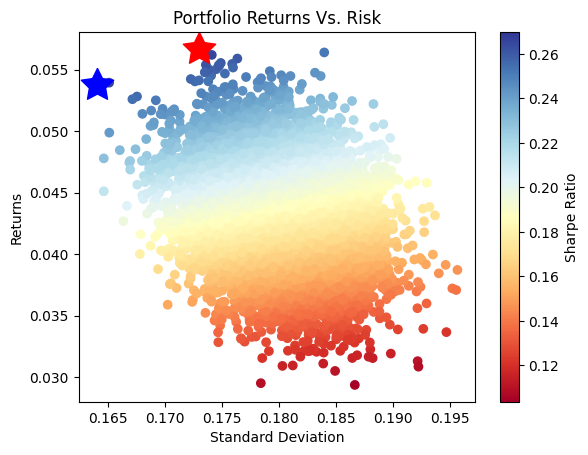

In [25]:
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()

# Monte Carlo with 10 portfolios in each monte carlo simulation

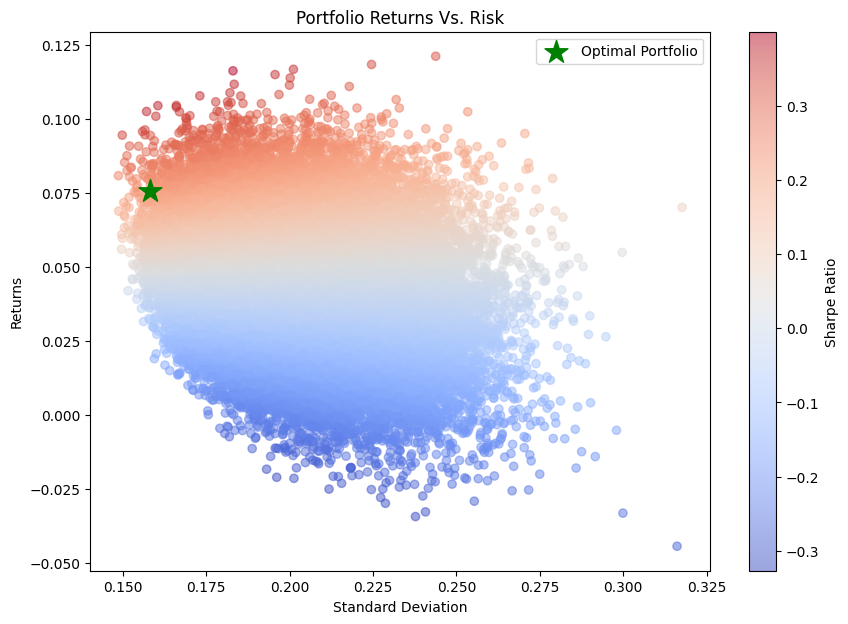

,Returns,Volatility,Sharpe Ratio,ESG Score,EXPN.L,ABF.L,RIO.L,RKT.L,WTB.L,AZN.L,IMB.L,INF.L,CRDA.L,RR.L
0,0.075585,0.158018,0.206213,81.053352,0.02487,0.11014,0.006205,0.199197,0.098198,0.180037,0.204791,0.071316,0.093034,0.012211


In [63]:
# Calculate the Log of returns
log_return = np.log(1 + portfolio_df.pct_change())

# Monte Carlo Simulation parameters
num_of_portfolios = 50000
risk_free_rate = 0.043
num_of_constituents = 10  # Number of constituents in each random portfolio

# Prepare arrays to store the simulation results
ret_arr = np.zeros(num_of_portfolios)
vol_arr = np.zeros(num_of_portfolios)
sharpe_arr = np.zeros(num_of_portfolios)
esg_arr = np.zeros(num_of_portfolios)
all_weights = []
all_symbols = []

# Convert ESG scores to a dictionary for easy lookup
esg_scores_dict = top_per_sector.set_index('Instrument')['ESG Score'].to_dict()

# Start the simulations
for ind in range(num_of_portfolios):
    # Randomly select 10 symbols
    selected_symbols = np.random.choice(portfolio_df.columns, num_of_constituents, replace=False)
    
    # Extract data for the selected symbols
    selected_log_return = log_return[selected_symbols]
    
    # Generate random portfolio weights
    weights = np.random.random(num_of_constituents)
    weights /= np.sum(weights)
    
    # Store the weights and symbols
    all_weights.append(weights)
    all_symbols.append(selected_symbols)
    
    # Calculate expected returns and add to returns array
    ret_arr[ind] = np.sum((selected_log_return.mean() * weights) * 252)
    
    # Calculate volatility and add to volatility array
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(selected_log_return.cov() * 252, weights)))
    
    # Calculate Sharpe ratio and add to Sharpe ratio array
    sharpe_arr[ind] = (ret_arr[ind] - risk_free_rate) / vol_arr[ind]
    
    # Extract ESG scores for the selected symbols
    esg_scores = np.array([esg_scores_dict[symbol] for symbol in selected_symbols])
    
    # Calculate ESG score and add to ESG array
    esg_arr[ind] = np.sum(esg_scores * weights)

# Create a DataFrame for the simulation results
simulations_df = pd.DataFrame({
    'Returns': ret_arr,
    'Volatility': vol_arr,
    'Sharpe Ratio': sharpe_arr,
    'ESG Score': esg_arr,
    'Symbols': all_symbols,
    'Weights': all_weights
})

# Define weights for the composite score
sharpe_weight = 0.5
esg_weight = 0.5

# Normalize Sharpe ratios and ESG scores
simulations_df['Normalized Sharpe'] = (simulations_df['Sharpe Ratio'] - simulations_df['Sharpe Ratio'].min()) / (simulations_df['Sharpe Ratio'].max() - simulations_df['Sharpe Ratio'].min())
simulations_df['Normalized ESG'] = (simulations_df['ESG Score'] - simulations_df['ESG Score'].min()) / (simulations_df['ESG Score'].max() - simulations_df['ESG Score'].min())

# Calculate the composite score
simulations_df['Composite Score'] = sharpe_weight * simulations_df['Normalized Sharpe'] + esg_weight * simulations_df['Normalized ESG']

# Find the portfolio with the highest composite score
optimal_portfolio = simulations_df.loc[simulations_df['Composite Score'].idxmax()]

# Extract the symbols and weights for the optimal portfolio
optimal_symbols = optimal_portfolio['Symbols']
optimal_weights = optimal_portfolio['Weights']

# Create a dictionary for the optimal portfolio data
optimal_portfolio_data = {
    'Returns': optimal_portfolio['Returns'],
    'Volatility': optimal_portfolio['Volatility'],
    'Sharpe Ratio': optimal_portfolio['Sharpe Ratio'],
    'ESG Score': optimal_portfolio['ESG Score']
}
optimal_portfolio_data.update({optimal_symbols[i]: optimal_weights[i] for i in range(num_of_constituents)})

# Convert the dictionary to a DataFrame
optimal_portfolio_df = pd.DataFrame([optimal_portfolio_data])

# Plotting the Monte Carlo simulation results
plt.figure(figsize=(10, 7))
plt.scatter(simulations_df['Volatility'], simulations_df['Returns'], c=simulations_df['Sharpe Ratio'], cmap='coolwarm', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_portfolio['Volatility'], optimal_portfolio['Returns'], marker='*', color='g', s=300, label='Optimal Portfolio')
plt.title('Portfolio Returns Vs. Risk')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Print the optimal portfolio
optimal_portfolio_df


# Optimization

Alright, now remember that up above I mentioned that we would be exploring multiple ways to optimize our portfolio. The first was using Monte Carlo Simulation that would try thousands of random values and find the best values. The draw back to using the Monte Carlo Simulation is that it's not the most efficent way to find the optimial values. Instead we can use mathematical techniques to easily arrive at the optimial values.

To help run this new optimization method, we will need to define a few more functions that we will use in our method. The first function is the `get_metrics()` function which will return the metrics for a given set of weights provided. In other words, think of it as a "lookup function" where we can return the results of a certain weight. The second function is the `neg_sharpe` function which is used as a minimization function. The minimization function is used to help find the values which results in the lowest sharpe ratio. In Scipy’s optimize function, there’s no `maximize`, so as an objective function you need to pass something that should be minimized.

The third function is `check_sum` function which is used as a constraint. What is will do is make sure that the weights that are passed through meet the constraint that we must have a portfolio allocation equal 100%, not more and not less.

In [64]:
# Define the optimization function
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    returns = np.sum(mean_returns * weights) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = (returns - risk_free_rate) / volatility
    return -sharpe_ratio

def check_sum(weights):
    return np.sum(weights) - 1

# Function to perform optimization on given portfolios
def optimize_portfolio(initial_weights, mean_returns, cov_matrix, esg_scores, risk_free_rate):
    bounds = tuple((0, 1) for _ in range(len(initial_weights)))
    constraints = (
        {'type': 'eq', 'fun': check_sum},
        {'type': 'ineq', 'fun': lambda weights: np.sum(weights * esg_scores) - esg_threshold}
    )
    result = minimize(
        negative_sharpe_ratio,
        initial_weights,
        args=(mean_returns, cov_matrix, risk_free_rate),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result

# Assuming mean_returns, cov_matrix, and esg_scores_dict are defined
# Define risk-free rate and ESG threshold
risk_free_rate = 0.043  # Example risk-free rate
esg_threshold = 80  # Example threshold for minimum ESG score

optimized_results = []

for idx, row in optimal_portfolio_df.iterrows():
    # Extract symbols and weights from the row
    selected_symbols = row.index[4:]  # Symbols start from the 5th column onward
    initial_weights = row[selected_symbols].values
    esg_scores = np.array([esg_scores_dict[symbol] for symbol in selected_symbols])

    # Assume mean_returns and cov_matrix are previously calculated for these symbols
    selected_log_return = log_return[selected_symbols]
    
    result = optimize_portfolio(initial_weights, selected_log_return.mean(), selected_log_return.cov(), esg_scores, risk_free_rate)

    optimized_weights = result.x
    optimized_return = np.sum(selected_log_return.mean() * optimized_weights) * 252
    optimized_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(selected_log_return.cov() * 252, optimized_weights)))
    optimized_sharpe = (optimized_return - risk_free_rate) / optimized_volatility
    optimized_esg = np.sum(optimized_weights * esg_scores)
    
    # Ensure weights sum to one
    weight_sum = np.sum(optimized_weights)
    assert np.isclose(weight_sum, 1), f"Weights do not sum to 1, sum = {weight_sum}"

    optimized_results.append({
        'Returns': optimized_return,
        'Volatility': optimized_volatility,
        'Sharpe Ratio': optimized_sharpe,
        'ESG Score': optimized_esg,
        **{symbol: weight for symbol, weight in zip(selected_symbols, optimized_weights)}
    })

# Convert the optimized results to a DataFrame
optimized_df = pd.DataFrame(optimized_results)

# Display the optimized portfolio metrics
optimized_df


,Returns,Volatility,Sharpe Ratio,ESG Score,EXPN.L,ABF.L,RIO.L,RKT.L,WTB.L,AZN.L,IMB.L,INF.L,CRDA.L,RR.L
0,0.099755,0.182527,0.310939,80.0,0.16602,0.029613,0.0,0.282606,3.047963e-17,0.094639,0.014575,0.0,0.412548,9.358020e-18
